# Clustering para Plan de Expansión de Tiendas

Este proyecto aplica técnicas de clustering para identificar áreas óptimas para la apertura de nuevos centros comerciales utilizando información censal, permitiendo segmentar regiones según perfiles de clientes que se adapten a diferentes tipologías de establecimientos.

## Plan de expansión: apertura de nuevas tiendas

## Contexto del Problema

Una cadena de supermercados desea identificar áreas en las que abrir nuevos centros comerciales.

Utilizando información censal (tabla CENSUS2000), el objetivo es encontrar áreas cuyos perfiles de clientes se adapten a diferentes tipologías de centros: boutiques, supermercados de presupuesto medio, grandes superficies, etc.

Se supone que el país tiene una densidad muy baja de establecimientos comerciales y se puede seguir abriendo tiendas en las diferentes regiones, por lo que la identificación de áreas óptimas es crucial para el éxito de la expansión.

<img src="tienda.jpg">

## Configuración del Entorno

Es recomendable declarar en un bloque al inicio todos los paquetes que se utilizarán en este notebook:

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import folium
from folium import plugins

## Carga y Exploración de Datos

### Información del Dataset Census2000

Utilizamos un dataset con información censal (tabla CENSUS2000) que contiene las siguientes variables:

- **Numrow**: Número de fila
- **ID**: Identificador del registro
- **LocX y LocY**: Coordenadas para geolocalizar las zonas
- **RegDens**: Densidad de población de la región
- **RegPop**: Número de habitantes de la región
- **MedHHInc**: Nivel de ingresos medio de la unidad familiar
- **MeanHHSz**: Tamaño medio de la unidad familiar (HH = Household)

Los datos se encuentran en el fichero `census2000.csv`.

### Carga de Datos

Cargamos los datos en un DataFrame para comenzar el análisis.

In [5]:
dfc=pd.read_csv("census2000.csv")

### Inspección Inicial de los Datos

Una vez cargados los datos, los inspeccionamos para comprender su estructura antes de comenzar el análisis.

In [6]:
dfc.head()

,Numrow,ID,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
0,0,00601,-66.749472,18.180103,70.0,19143.0,9888.0,3.24
1,1,00602,-67.180247,18.363285,83.0,42042.0,11384.0,3.10
2,2,00603,-67.134224,18.448619,86.0,55592.0,10748.0,2.84
3,3,00604,-67.136995,18.498987,83.0,3844.0,31199.0,3.00
4,4,00606,-66.958807,18.182151,65.0,6449.0,9243.0,3.20


### Dimensiones del Dataset

Verificamos cuántos registros y columnas tiene el dataset para entender su tamaño.

In [7]:
dfc.shape

(33178, 8)

### Tipos de Datos

Verificamos los tipos de datos de cada columna para asegurar que están en el formato correcto para el análisis.

In [8]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Numrow    33178 non-null  int64  
 1   ID        33178 non-null  object 
 2   LocX      33178 non-null  float64
 3   LocY      33178 non-null  float64
 4   RegDens   32165 non-null  float64
 5   RegPop    33178 non-null  float64
 6   MedHHInc  33178 non-null  float64
 7   MeanHHSz  33178 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB


## Filtrado y Preprocesamiento de Datos

### Análisis de Unidades Familiares

Una particularidad de este dataset es que contiene información sobre hogares que no tienen miembros en la unidad familiar. Verificamos cuántos registros tienen unidades familiares iguales o superiores a 1.

In [9]:
# Count records with MeanHHSz >= 1
records_gte_1 = dfc[dfc['MeanHHSz'] >= 1].shape[0]
records_gte_1

32079

### Filtrado de Datos

Para este análisis, trabajamos solo con aquellos registros que tienen unidades familiares mayores o iguales que 2, ya que estos representan hogares con al menos 2 miembros, lo cual es más relevante para el análisis de mercado. Filtramos los datos en consecuencia.

In [10]:
dfc_filtered = dfc[dfc['MeanHHSz'] >= 2].copy()
dfc_filtered 


,Numrow,ID,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
0,0,00601,-66.749472,18.180103,70.0,19143.0,9888.0,3.24
1,1,00602,-67.180247,18.363285,83.0,42042.0,11384.0,3.10
2,2,00603,-67.134224,18.448619,86.0,55592.0,10748.0,2.84
3,3,00604,-67.136995,18.498987,83.0,3844.0,31199.0,3.00
4,4,00606,-66.958807,18.182151,65.0,6449.0,9243.0,3.20
...,...,...,...,...,...,...,...,...
33172,33172,99926,-131.568839,55.123897,16.0,1447.0,43516.0,2.95
33173,33173,99927,-133.606896,56.337957,15.0,136.0,17143.0,2.03
33174,33174,99929,-132.338228,56.409507,5.0,2424.0,43696.0,2.49
33175,33175,99950,-131.466339,55.875767,2.0,47.0,37708.0,2.14


### Resultado del Filtrado

Hemos filtrado los datos y podemos verificar el resultado. El dataset filtrado contiene solo registros con unidades familiares de 2 o más miembros.

## Visualización de los Datos

### Análisis Exploratorio Visual

Para comprender mejor los datos, generamos gráficos con las principales características. Utilizamos gráficos de dispersión para la distribución geográfica, histogramas para las distribuciones de variables numéricas, y otros tipos de visualizaciones según sea necesario.

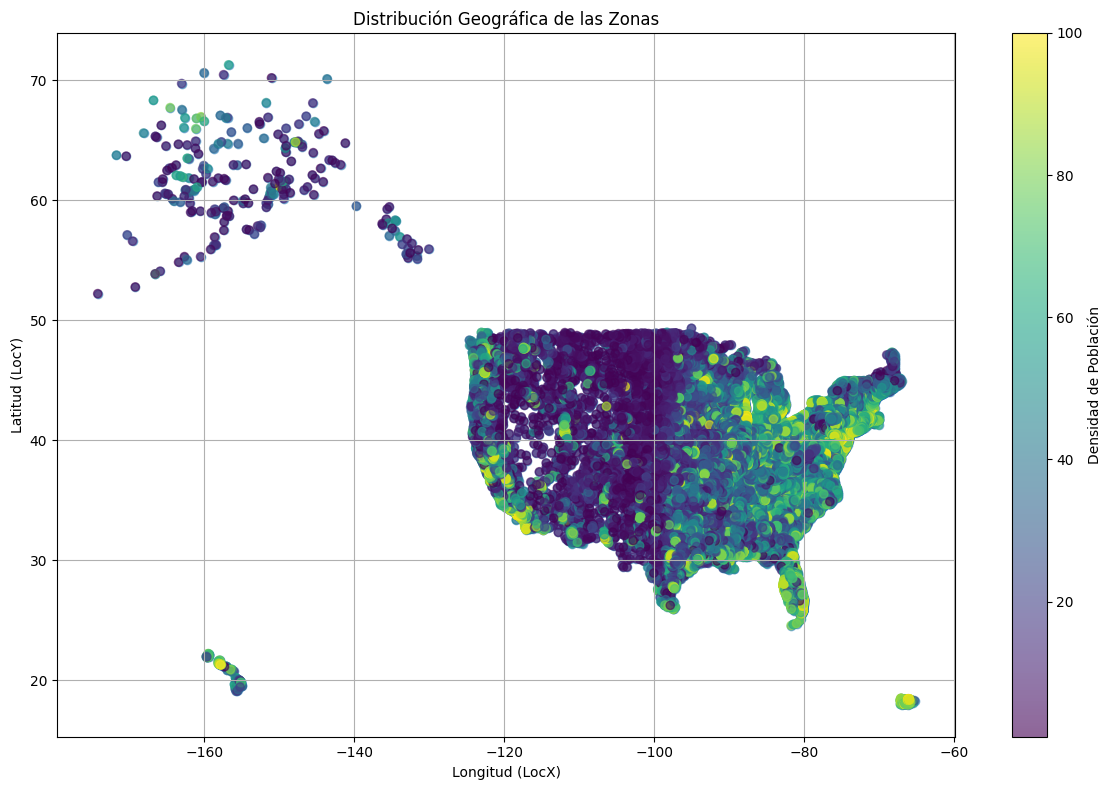

In [11]:
# Crear gráfico de dispersión de las coordenadas
plt.figure(figsize=(12, 8))
plt.scatter(dfc_filtered['LocX'], dfc_filtered['LocY'], alpha=0.5)
plt.title('Distribución Geográfica de las Zonas')
plt.xlabel('Longitud (LocX)')
plt.ylabel('Latitud (LocY)')
plt.grid(True)

# Añadir un colorbar basado en la densidad de población
scatter = plt.scatter(dfc_filtered['LocX'], dfc_filtered['LocY'], 
                     c=dfc_filtered['RegDens'],
                     cmap='viridis',
                     alpha=0.6)
plt.colorbar(scatter, label='Densidad de Población')

plt.tight_layout()
plt.show()

In [12]:
# 2. Crear un mapa centrado en el punto medio de las coordenadas
center_lat = dfc_filtered['LocY'].mean()
center_lon = dfc_filtered['LocX'].mean()

# Crear el mapa base
m = folium.Map(location=[center_lat, center_lon], 
               zoom_start=4,
               tiles='OpenStreetMap')

# Añadir marcadores para cada punto
# Usamos MarkerCluster para mejor rendimiento con muchos puntos
marker_cluster = plugins.MarkerCluster().add_to(m)

# Añadir cada punto al mapa
for idx, row in dfc_filtered.iterrows():
    # Crear popup con información relevante
    popup_text = f"""
    Población: {int(row['RegPop'])}
    Densidad: {row['RegDens']:.1f}
    Ingreso medio: ${int(row['MedHHInc'])}
    Tamaño familiar: {row['MeanHHSz']:.2f}
    """
    
    folium.Marker(
        location=[row['LocY'], row['LocX']],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(marker_cluster)

# Añadir control de escala
folium.plugins.MiniMap().add_to(m)
folium.plugins.Fullscreen().add_to(m)


# Mostrar el mapa
#descomentar para ver el mapa es muy pesado
#m



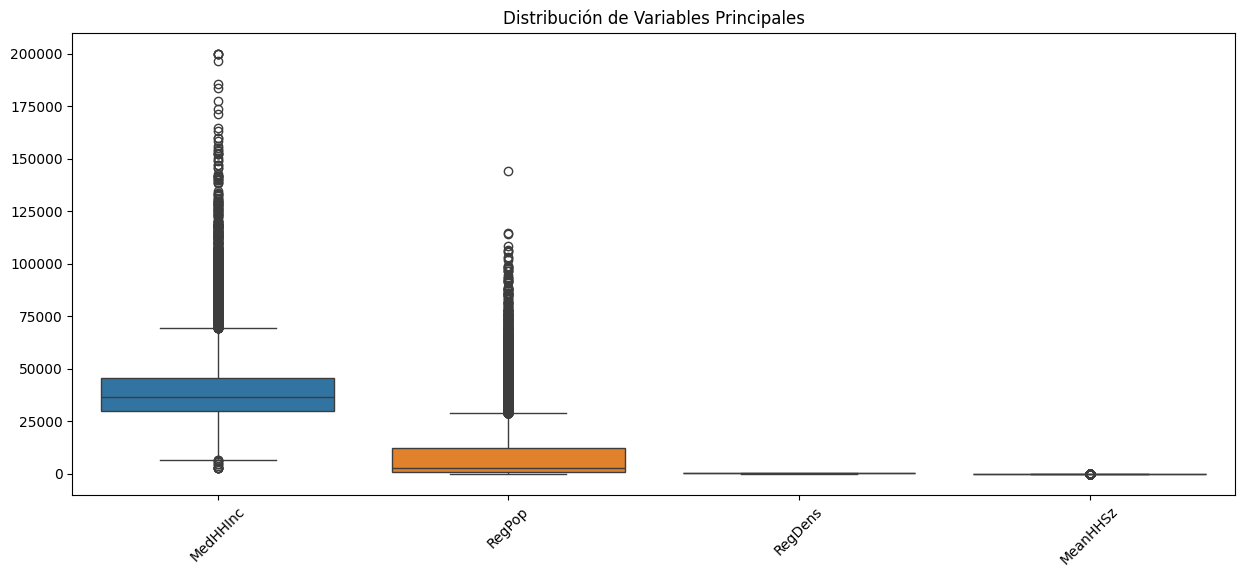

In [13]:
# Análisis de distribución con boxplots
plt.figure(figsize=(15, 6))
sns.boxplot(data=dfc_filtered[['MedHHInc', 'RegPop', 'RegDens', 'MeanHHSz']])
plt.title('Distribución de Variables Principales')
plt.xticks(rotation=45)
plt.show()



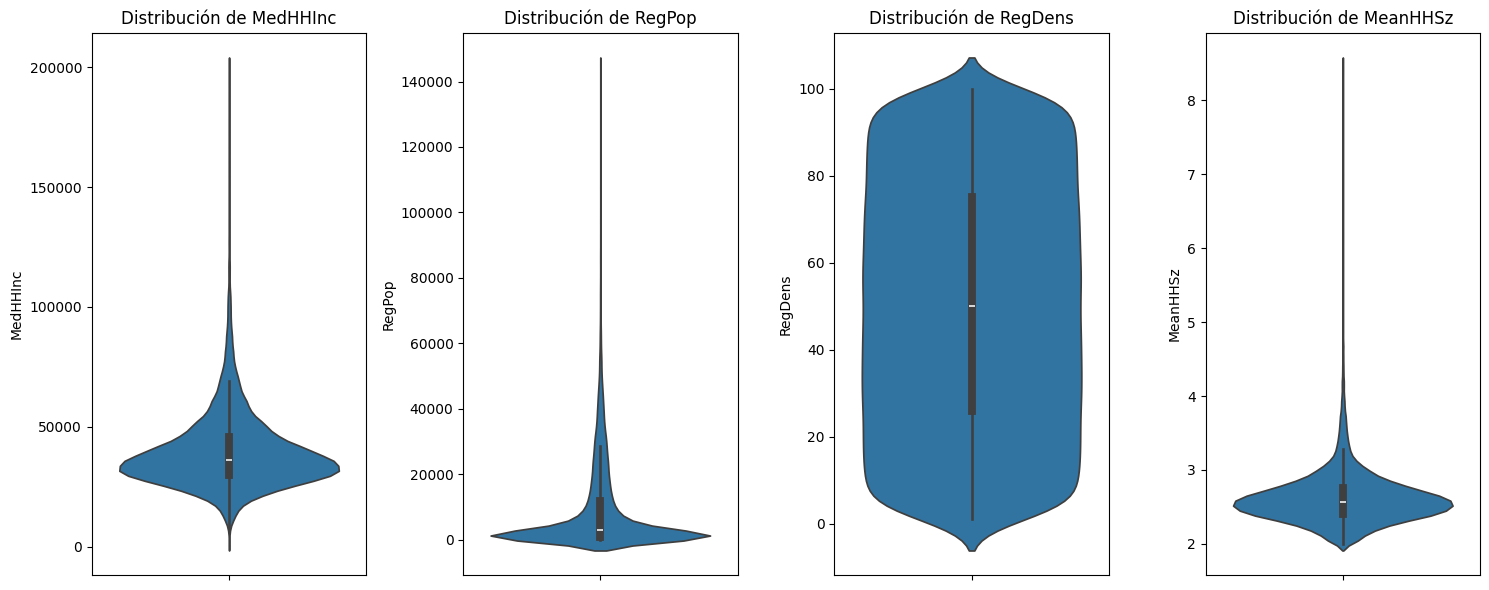

In [14]:

# Violin plots para cada variable
plt.figure(figsize=(15, 6))
variables = ['MedHHInc', 'RegPop', 'RegDens', 'MeanHHSz']
for i, var in enumerate(variables):
    plt.subplot(1, 4, i+1)
    sns.violinplot(y=dfc_filtered[var])
    plt.title(f'Distribución de {var}')
plt.tight_layout()
plt.show()


In [15]:

# Test de Tukey para identificar outliers
from scipy import stats

def tukey_outliers(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[variable] < lower_bound) | (data[variable] > upper_bound)][variable]
    
    print(f"\nAnálisis de outliers para {variable}:")
    print(f"Límite inferior: {lower_bound:.2f}")
    print(f"Límite superior: {upper_bound:.2f}")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Porcentaje de outliers: {(len(outliers)/len(data))*100:.2f}%")
    
    return outliers



Análisis de outliers para MedHHInc:
Límite inferior: 6298.50
Límite superior: 69318.50
Número de outliers: 1569
Porcentaje de outliers: 5.08%


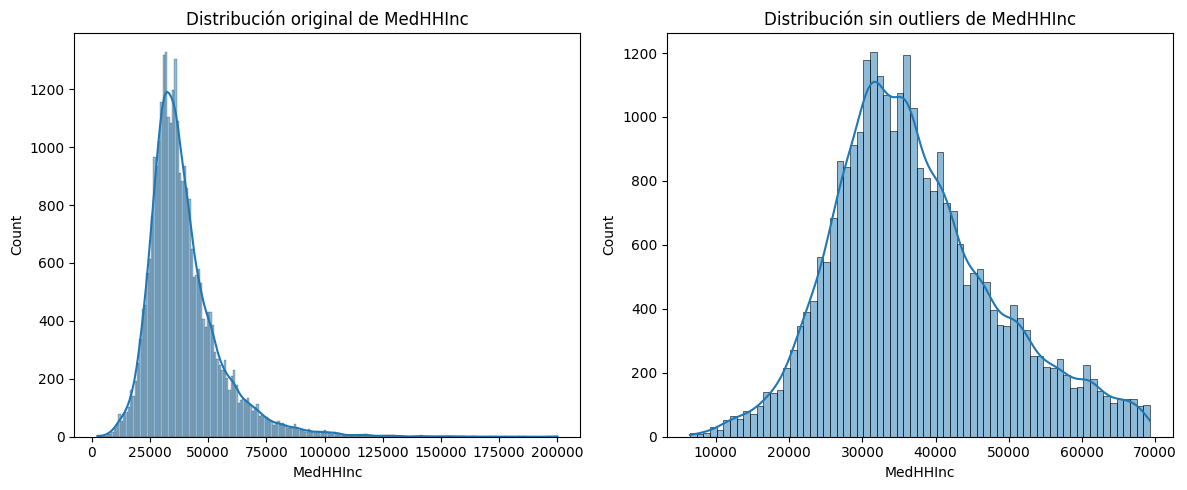


Análisis de outliers para RegPop:
Límite inferior: -15897.00
Límite superior: 28663.00
Número de outliers: 2940
Porcentaje de outliers: 9.51%


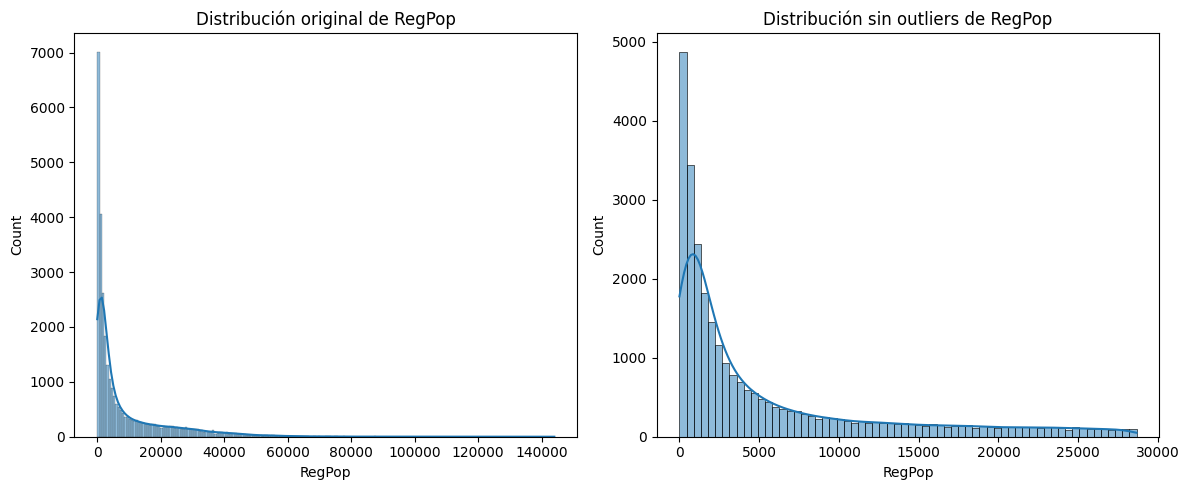


Análisis de outliers para RegDens:
Límite inferior: -47.50
Límite superior: 148.50
Número de outliers: 0
Porcentaje de outliers: 0.00%


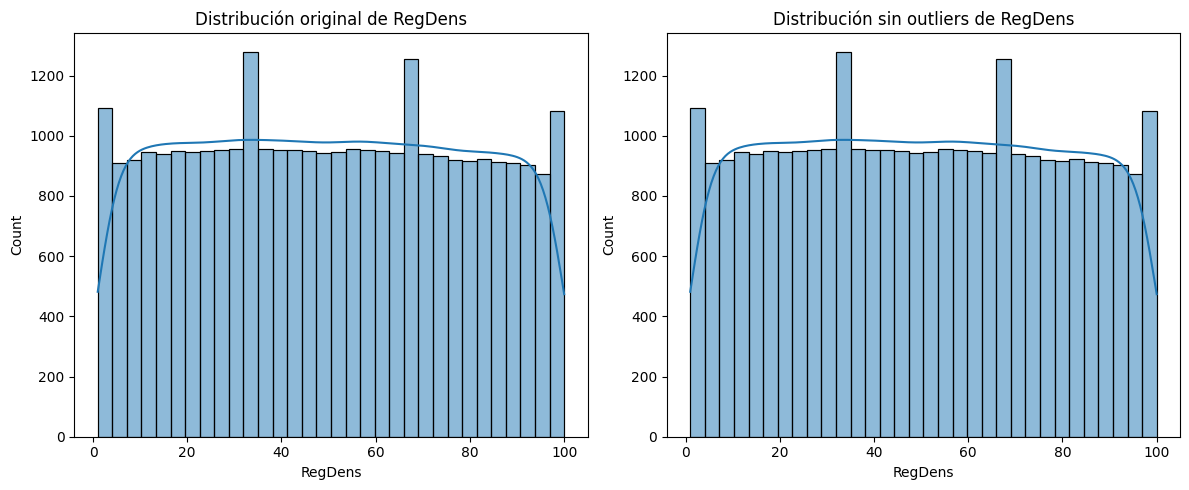


Análisis de outliers para MeanHHSz:
Límite inferior: 1.88
Límite superior: 3.29
Número de outliers: 1303
Porcentaje de outliers: 4.22%


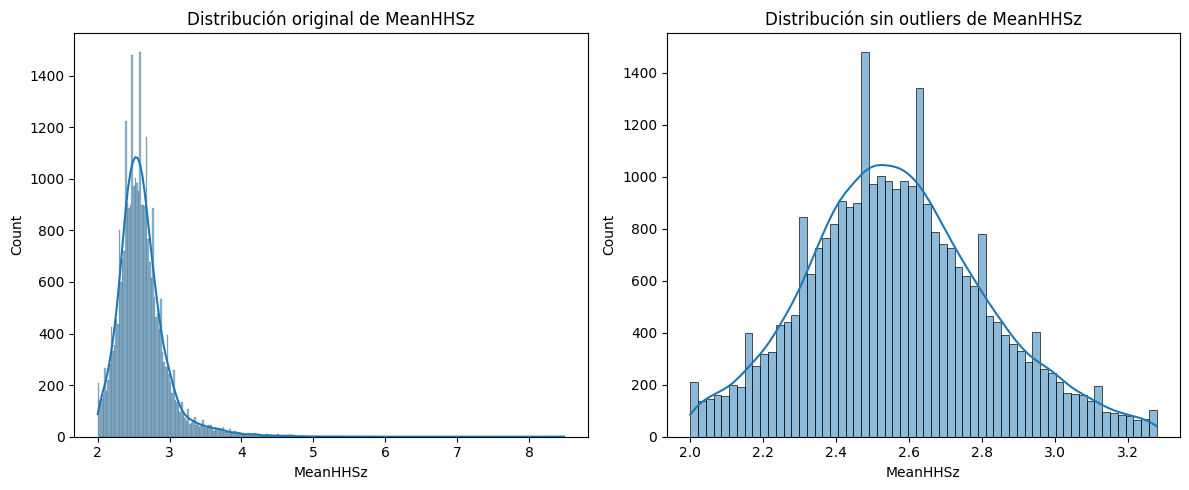

In [16]:

# Aplicar test de Tukey a cada variable
for var in variables:
    outliers = tukey_outliers(dfc_filtered, var)
    
    # Visualizar distribución sin outliers
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=dfc_filtered[var], kde=True)
    plt.title(f'Distribución original de {var}')
    
    plt.subplot(1, 2, 2)
    data_no_outliers = dfc_filtered[~dfc_filtered[var].isin(outliers)][var]
    sns.histplot(data=data_no_outliers, kde=True)
    plt.title(f'Distribución sin outliers de {var}')
    
    plt.tight_layout()
    plt.show()

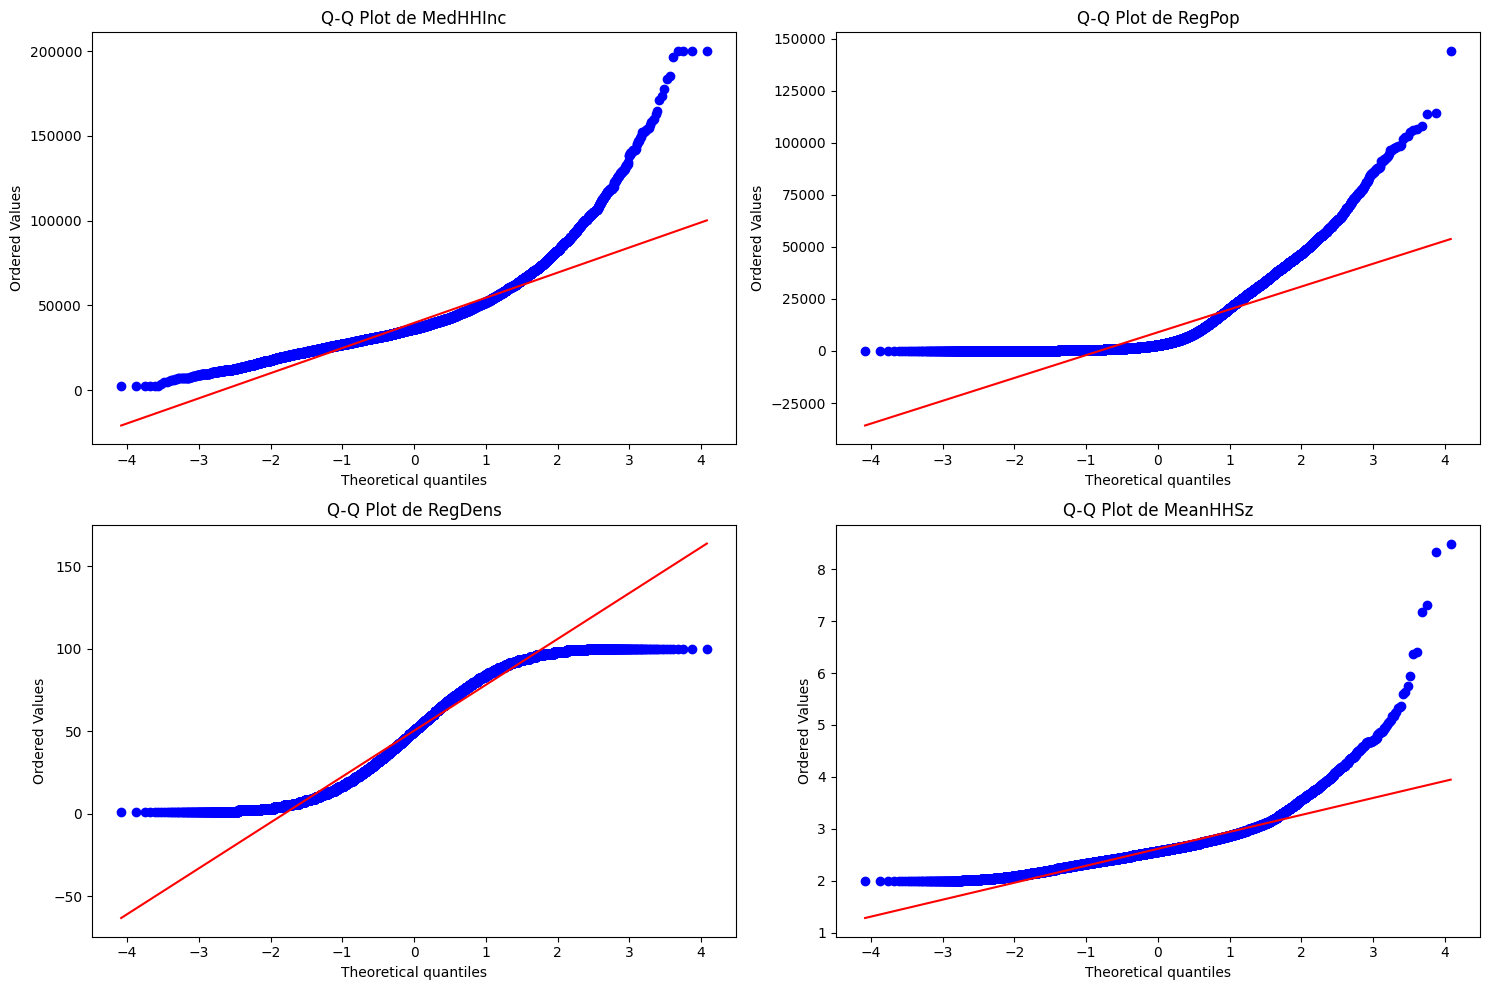

In [17]:
# Análisis de normalidad
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    stats.probplot(dfc_filtered[var], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {var}')
plt.tight_layout()
plt.show()


In [18]:

# Test de normalidad
print("\nTest de Normalidad (Shapiro-Wilk):")
for var in variables:
    stat, p_value = stats.shapiro(dfc_filtered[var])
    print(f"\n{var}:")
    print(f"Estadístico: {stat:.4f}")
    print(f"P-valor: {p_value:.4e}")
    print("Normal" if p_value > 0.05 else "No normal")



Test de Normalidad (Shapiro-Wilk):

MedHHInc:
Estadístico: 0.8646
P-valor: 1.5457e-93
No normal

RegPop:
Estadístico: 0.6955
P-valor: 1.7667e-114
No normal

RegDens:
Estadístico: 0.9570
P-valor: 1.3792e-67
No normal

MeanHHSz:
Estadístico: 0.8647
P-valor: 1.6369e-93
No normal


In [19]:

# Estadísticas descriptivas detalladas
print("\nEstadísticas descriptivas:")
stats_df = dfc_filtered[variables].describe()
stats_df.loc['skew'] = dfc_filtered[variables].skew()
stats_df.loc['kurtosis'] = dfc_filtered[variables].kurtosis()
print(stats_df)



Estadísticas descriptivas:
               MedHHInc         RegPop       RegDens      MeanHHSz
count      30899.000000   30899.000000  30899.000000  30899.000000
mean       39682.335286    8999.441244     50.202207      2.618091
std        15938.201292   13154.755607     28.414435      0.350701
min         2499.000000       4.000000      1.000000      2.000000
25%        29931.000000     813.000000     26.000000      2.410000
50%        36250.000000    2808.000000     50.000000      2.570000
75%        45686.000000   11953.000000     75.000000      2.760000
max       200001.000000  144024.000000    100.000000      8.490000
skew           2.008826       2.286478      0.015102      2.264793
kurtosis       8.072687       6.506770     -1.181755     14.088002


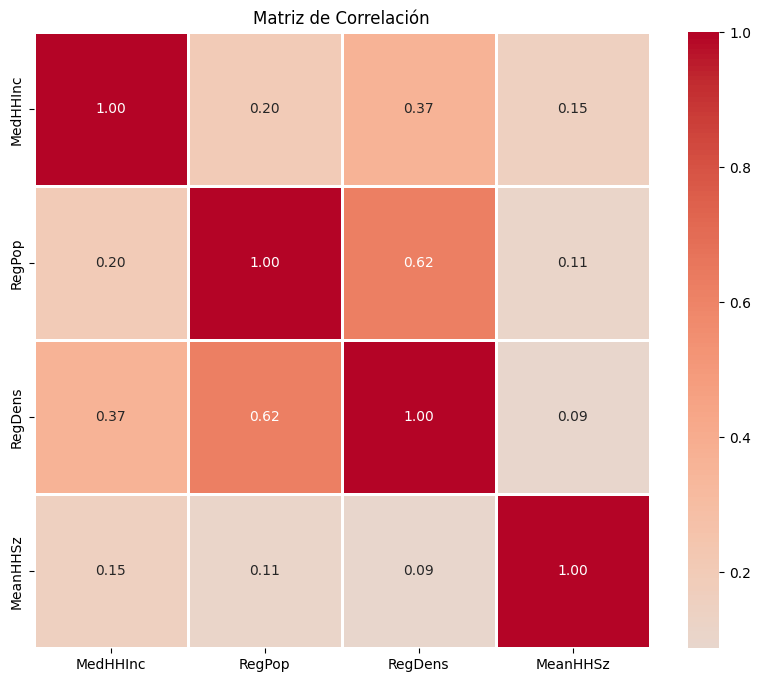

In [20]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = dfc_filtered[variables].corr()
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            linewidths=2)
plt.title('Matriz de Correlación')
plt.show()

### Interpretación de las Visualizaciones

Analizamos qué nos indican estos gráficos sobre la estructura y características de los datos.


In [ ]:
**Interpretación de la distribución geográfica:**

- Los datos cubren todo Estados Unidos, proporcionando una cobertura nacional completa
- Se observa una mayor densidad de población en las costas y zonas urbanas, lo cual es consistente con los patrones demográficos conocidos
- Existen clusters naturales en áreas metropolitanas, visualizados claramente en el mapa de calor, lo que sugiere agrupaciones geográficas que pueden ser útiles para el análisis de clustering

'\nDistribución Geográfica:\n    - Los datos cubren todo Estados Unidos\n    - Hay una mayor densidad de población en las costas y zonas urbanas\n    - Existen clusters naturales en áreas metropolitanas (visualizado en el mapa de calor)\n'

### Análisis de Normalidad de los Datos

Evaluamos si los datos siguen una distribución normal generando histogramas para cada variable y verificando si presentan forma de campana (distribución gaussiana).

In [ ]:
**Análisis de variables:**

**MedHHInc (Ingreso medio por hogar):**
- Distribución asimétrica positiva (skew = 2.01)
- Presencia de outliers (5.08%)
- Media: $39,682
- Alta variabilidad (CV = 40.16%)
- No sigue una distribución normal

**RegPop (Población regional):**
- Fuerte asimetría positiva (skew = 2.29)
- Alto porcentaje de outliers (9.51%)
- Gran variabilidad (CV = 146.17%)
- Concentración en valores bajos con algunos picos altos
- No normal

**RegDens (Densidad regional):**
- Distribución más uniforme
- No presenta outliers
- Asimetría cercana a 0 (0.015)
- Distribución bimodal
- No normal pero más cercana a la normalidad

**MeanHHSz (Tamaño medio del hogar):**
- Asimetría positiva (skew = 2.26)
- 4.22% de outliers
- Menor variabilidad (CV = 13.39%)
- Concentrado entre 2-3 personas por hogar
- No normal

**Conclusiones:**
- Ninguna variable sigue una distribución normal
- Todas tienen p-valores muy por debajo del nivel de significancia (0.05)
- Las distribuciones muestran patrones claramente no gaussianos, lo que justifica la aplicación de transformaciones

'\nAnálisis de Variables:\n\n    MedHHInc (Ingreso medio por hogar):\n        - Distribución asimétrica positiva (skew = 2.01)\n        - Presencia de outliers (5.08%)\n        - Media: $39,682\n        - Alta variabilidad (CV = 40.16%)\n        - No sigue una distribución normal\n\n    RegPop (Población regional):\n        - Fuerte asimetría positiva (skew = 2.29)\n        - Alto porcentaje de outliers (9.51%)\n        - Gran variabilidad (CV = 146.17%)\n        - Concentración en valores bajos con algunos picos altos\n        - No normal\n\n    RegDens (Densidad regional):\n        - Distribución más uniforme\n        - No presenta outliers\n        - Asimetría cercana a 0 (0.015)\n        - Distribución bimodal\n        - No normal pero más cercana a la normalidad\n\n    MeanHHSz (Tamaño medio del hogar):\n        - Asimetría positiva (skew = 2.26)\n        - 4.22% de outliers\n        - Menor variabilidad (CV = 13.39%)\n        - Concentrado entre 2-3 personas por hogar\n        - 

### Análisis de Relaciones entre Variables

Revisamos las relaciones que existen entre las variables mediante gráficos de dispersión y el cálculo del coeficiente de correlación para identificar relaciones lineales entre las variables del dataset.

In [ ]:
**Análisis de correlaciones:**

- **Correlación moderada** entre RegPop y RegDens (0.62): La población regional está relacionada con la densidad, lo cual es lógico desde el punto de vista demográfico.

- **Correlación débil-moderada** entre MedHHInc y RegDens (0.37): Existe una relación positiva pero no muy fuerte entre ingresos y densidad poblacional.

- **Correlaciones débiles** entre las demás variables: La mayoría de las relaciones son débiles, lo que sugiere que las variables aportan información relativamente independiente.

- **MeanHHSz** muestra la menor correlación con otras variables: El tamaño del hogar parece ser una variable más independiente, lo cual puede ser útil para la segmentación.

'\nAmpliando un poco lo anterior:\n    - Correlación moderada entre RegPop y RegDens (0.62)\n    - Correlación débil-moderada entre MedHHInc y RegDens (0.37)\n    - Correlaciones débiles entre las demás variables\n    - MeanHHSz muestra la menor correlación con otras variables\n'

### Notas sobre el Coeficiente de Correlación

El [coeficiente de correlación de Pearson](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) es una medida del grado de dependencia lineal entre dos variables. El coeficiente oscila entre -1 y 1:

- **Valor de 1**: Indica una correlación lineal perfecta positiva, donde todos los puntos de datos caen sobre una línea recta de pendiente positiva.
- **Valor de -1**: Indica una correlación lineal perfecta negativa, donde todos los puntos de datos se encuentran en una línea con pendiente negativa.
- **Valor de 0**: Indica que no existe una correlación lineal entre las variables.

Calculamos el coeficiente de correlación utilizando el método `corr()` de pandas.

In [24]:
# coeficiente de correlación
dfc_filtered[variables].corr()

,MedHHInc,RegPop,RegDens,MeanHHSz
MedHHInc,1.000000,0.202925,0.367567,0.154244
RegPop,0.202925,1.000000,0.623130,0.108856
RegDens,0.367567,0.623130,1.000000,0.087272
MeanHHSz,0.154244,0.108856,0.087272,1.000000


### Importante: Correlación no Implica Causalidad

Es fundamental recordar que **correlación no implica causalidad**. Una correlación entre dos variables indica que están relacionadas, pero no necesariamente que una cause la otra. Esta distinción es crucial en análisis estadísticos, ya que es común encontrar correlaciones espurias o relaciones que pueden ser explicadas por variables confusoras no consideradas en el análisis.

Para explorar ejemplos de correlaciones espurias, se puede consultar [Spurious Correlations](http://tylervigen.com/spurious-correlations), que muestra correlaciones estadísticamente significativas pero sin relación causal real.

<img src="correlacion.png" style="height: 150px">

## Transformación de Variables

Para aquellas variables que no cumplen con los criterios de normalidad, aplicamos transformaciones que permitan mejorar sus distribuciones. La transformación logarítmica es particularmente efectiva en estos casos, y después de aplicarla verificamos si los datos transformados se comportan de manera más cercana a una distribución normal.

**Ventajas de aplicar transformaciones:**

- **Reducción del efecto de outliers**: Las transformaciones logarítmicas comprimen los valores extremos, reduciendo su influencia desproporcionada en el análisis.

- **Inducción de normalidad**: En algunos casos, la transformación puede inducir normalidad, lo cual es una condición deseable aunque no estrictamente necesaria para muchos algoritmos.

- **Comparabilidad de rangos**: Las transformaciones permiten que los rangos de las variables sean más comparables, facilitando el análisis conjunto de variables con escalas muy diferentes.

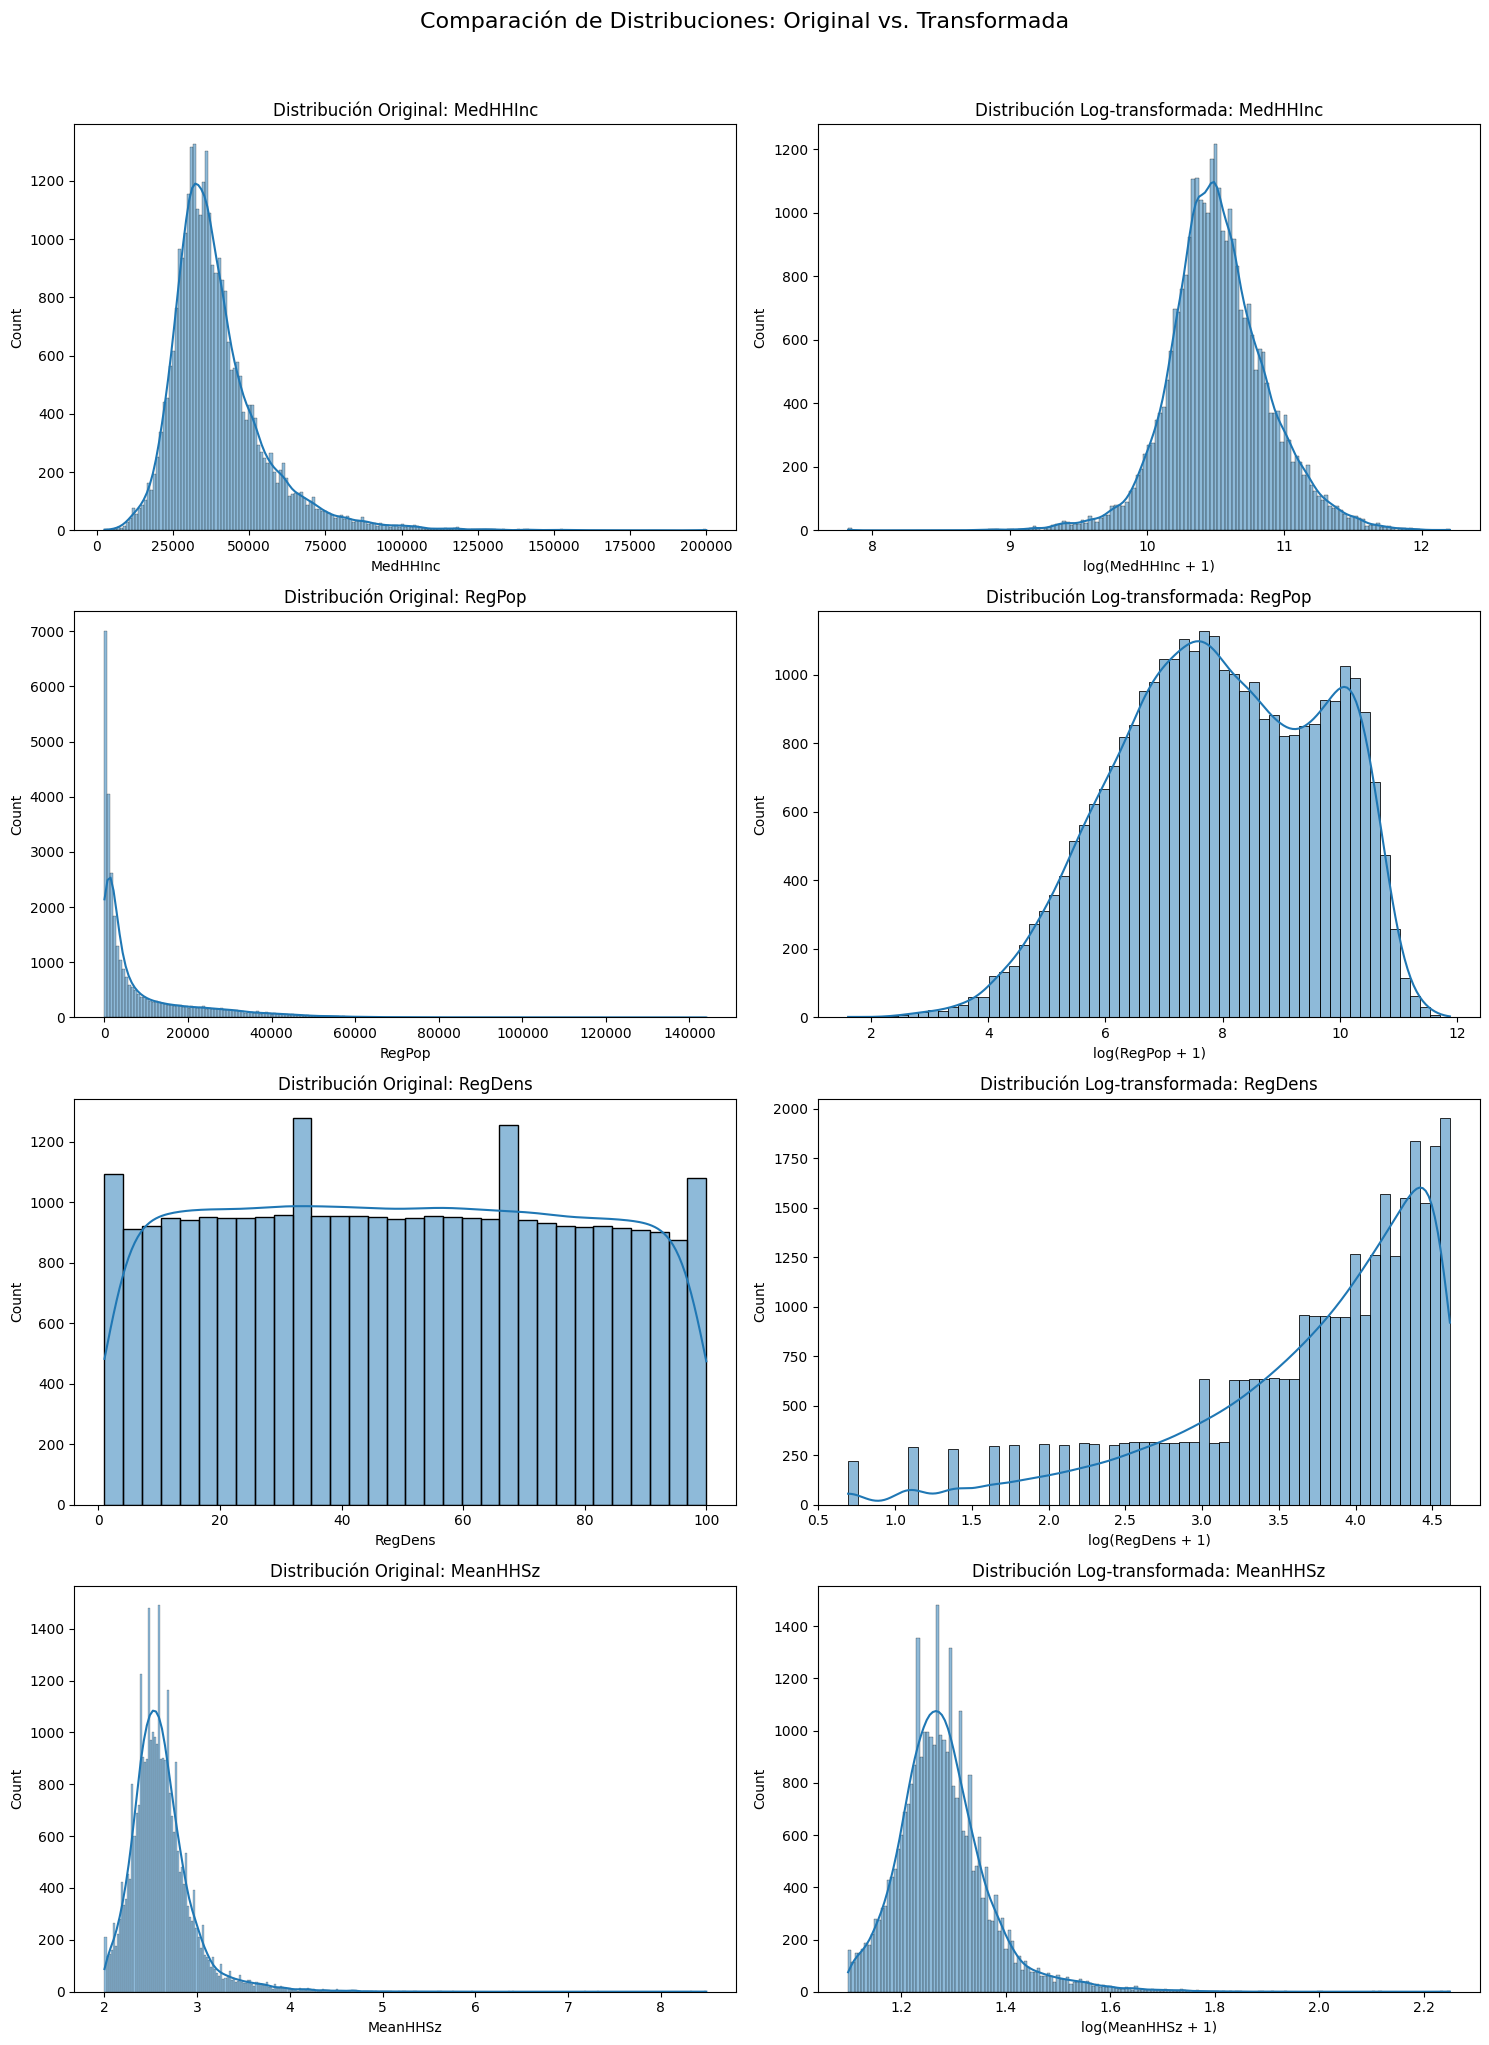


Estadísticas comparativas:

MedHHInc:
Original:
Asimetría: 2.01
Curtosis: 8.07
Rango: 197502.00

MedHHInc (log):
Asimetría: 0.02
Curtosis: 1.89
Rango: 4.38

RegPop:
Original:
Asimetría: 2.29
Curtosis: 6.51
Rango: 144020.00

RegPop (log):
Asimetría: -0.21
Curtosis: -0.66
Rango: 10.27

RegDens:
Original:
Asimetría: 0.02
Curtosis: -1.18
Rango: 99.00

RegDens (log):
Asimetría: -1.29
Curtosis: 1.33
Rango: 3.92

MeanHHSz:
Original:
Asimetría: 2.26
Curtosis: 14.09
Rango: 6.49

MeanHHSz (log):
Asimetría: 1.35
Curtosis: 4.94
Rango: 1.15

Test de normalidad (p-valores):

MedHHInc:
Original: 0.00e+00
Log-transformada: 1.17e-292

RegPop:
Original: 0.00e+00
Log-transformada: 0.00e+00

RegDens:
Original: 0.00e+00
Log-transformada: 0.00e+00

MeanHHSz:
Original: 0.00e+00
Log-transformada: 0.00e+00


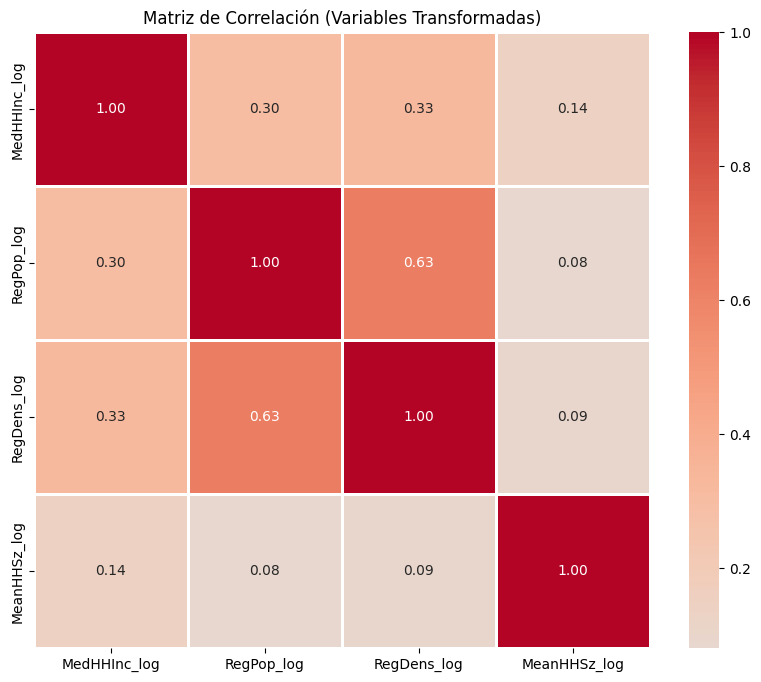

In [25]:
# 3. Transformación de variables para todas las variables numéricas
variables = ['MedHHInc', 'RegPop', 'RegDens', 'MeanHHSz']
df_transformed = dfc_filtered.copy()

# Aplicar transformación logarítmica a todas las variables
for var in variables:
    df_transformed[f'{var}_log'] = np.log1p(df_transformed[var])

# Visualizar comparaciones antes/después
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Comparación de Distribuciones: Original vs. Transformada', y=1.02, size=16)

# Para cada variable
for idx, var in enumerate(variables):
    # Distribución original
    sns.histplot(data=df_transformed[var], kde=True, ax=axes[idx,0])
    axes[idx,0].set_title(f'Distribución Original: {var}')
    axes[idx,0].set_xlabel(var)
    
    # Distribución transformada
    sns.histplot(data=df_transformed[f'{var}_log'], kde=True, ax=axes[idx,1])
    axes[idx,1].set_title(f'Distribución Log-transformada: {var}')
    axes[idx,1].set_xlabel(f'log({var} + 1)')

plt.tight_layout()
plt.show()

# Imprimir estadísticas comparativas
print("\nEstadísticas comparativas:")
for var in variables:
    print(f"\n{var}:")
    print("Original:")
    print(f"Asimetría: {df_transformed[var].skew():.2f}")
    print(f"Curtosis: {df_transformed[var].kurtosis():.2f}")
    print(f"Rango: {df_transformed[var].max() - df_transformed[var].min():.2f}")
    
    print(f"\n{var} (log):")
    print(f"Asimetría: {df_transformed[f'{var}_log'].skew():.2f}")
    print(f"Curtosis: {df_transformed[f'{var}_log'].kurtosis():.2f}")
    print(f"Rango: {df_transformed[f'{var}_log'].max() - df_transformed[f'{var}_log'].min():.2f}")

# Test de normalidad
print("\nTest de normalidad (p-valores):")
for var in variables:
    _, p_original = stats.normaltest(df_transformed[var])
    _, p_log = stats.normaltest(df_transformed[f'{var}_log'])
    print(f"\n{var}:")
    print(f"Original: {p_original:.2e}")
    print(f"Log-transformada: {p_log:.2e}")

# Matriz de correlación para variables transformadas
variables_log = [f'{var}_log' for var in variables]
correlation_matrix = df_transformed[variables_log].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            linewidths=2)
plt.title('Matriz de Correlación (Variables Transformadas)')
plt.show()

In [ ]:
**Análisis de las transformaciones logarítmicas:**

**1. MedHHInc (ingresos):**
- Se logró una distribución casi simétrica (asimetría de 2.01 a 0.02)
- Se redujo significativamente el efecto de los valores extremos
- La transformación fue muy efectiva para esta variable

**2. RegPop (población):**
- Se consiguió balancear mejor la distribución
- La asimetría mejoró notablemente (de 2.29 a -0.21)
- La transformación logarítmica fue muy beneficiosa

**3. RegDens (densidad):**
- La transformación cambió significativamente la forma de la distribución
- Se introdujo algo de asimetría negativa, pero la distribución se volvió más manejable

**4. MeanHHSz (tamaño del hogar):**
- La transformación tuvo menor impacto en esta variable
- Mejoró ligeramente la asimetría y curtosis, aunque el cambio fue menos dramático

**Matriz de correlación (variables transformadas):**
- Relación moderada entre población y densidad (0.63)
- Correlaciones débiles entre las demás variables
- Las relaciones se mantienen similares a las variables originales

**Conclusión:**
A pesar de que ninguna variable alcanza normalidad perfecta, las transformaciones mejoraron significativamente las distribuciones, haciéndolas más adecuadas para el análisis de clustering que se realizará posteriormente. Las variables transformadas presentan distribuciones más simétricas y con menor influencia de valores extremos.

'\nAnalizando las transformaciones logarítmicas observo que:\n\n    1. Para MedHHInc (ingresos):\n        - Se logrí una distribución casi simétrica (asimetría de 2.01 a 0.02)\n        - Se redujo significativamente los valores extremos\n        \n    2. Para RegPop (población):\n        - Se consiguió balancear mejor la distribución\n        - La asimetría mejoró notablemente (2.29 a -0.21)\n        \n    3. Para RegDens (densidad):\n        - Se observa que la transformación cambió significativamente la forma\n        Aunque se introdujo algo de asimetría negativa\n        \n    4. Para MeanHHSz (tamaño hogar):\n        - Observo que la transformación tuvo menor impacto\n        - Mejoró ligeramente la asimetría y curtosis\n\n    En la matriz de correlación veo:\n        - Relación moderada entre población y densidad (0.63)\n        - Correlaciones débiles entre las demás variables\n        \n    Conclusión:\n        A pesar de que ninguna variable alcanza normalidad perfecta,\n     

<img src="logaritmo.png" style="height: 200px">

## Preprocesamiento de Datos

Realizamos un tratamiento completo de los datos para prepararlos adecuadamente para el análisis de clustering. El proceso incluye las siguientes tareas:

### Estrategia de Preprocesamiento

**3.1.1. Imputación de valores faltantes:**
La única variable que contiene valores faltantes es `RegDens`. Para imputar estos valores, utilizamos un modelo de regresión que predice los valores faltantes a partir de las demás variables explicativas (RegPop, MedHHInc, MeanHHSz).

**3.1.2. Tratamiento de outliers:**
Se identifican y analizan las observaciones atípicas respecto de cada una de las variables. Aunque se podría filtrar estas observaciones, esto implicaría la pérdida de algunas regiones, lo cual no es deseable si queremos mantener la cobertura geográfica completa.

**3.1.3. Transformación de variables:**
Alternativamente, o de forma adicional, aplicamos transformaciones logarítmicas a las variables para reducir el efecto de los outliers sin perder registros, aprovechando las ventajas mencionadas anteriormente.


Outliers en MedHHInc: 1569 (5.08%)

Outliers en RegPop: 2940 (9.51%)

Outliers en RegDens: 0 (0.00%)

Outliers en MeanHHSz: 1303 (4.22%)

Dimensiones del dataset preparado: (30899, 12)

Columnas del dataset final:
['MedHHInc_scaled', 'RegPop_scaled', 'RegDens_scaled', 'MeanHHSz_scaled']


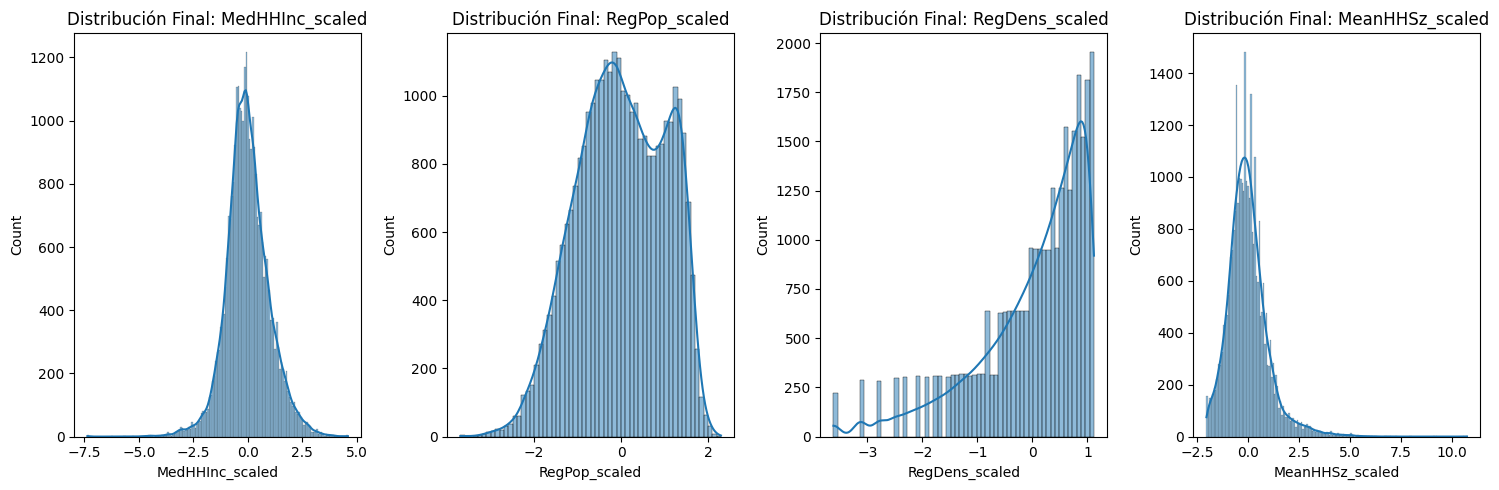

'\nEn este proceso de preparación de datos:\n\n    1. Imputación:\n        - Verifiqué si había valores faltantes en RegDens\n        - Preparé un modelo de regresión para imputar si fuera necesario\n        \n    2. Outliers:\n        - Identifiqué outliers usando método IQR\n        - Mantuve los outliers pero los transformé con log\n        \n    3. Transformaciones:\n        - Apliqué log1p a todas las variables\n        - Normalicé usando StandardScaler\n\n'

In [27]:
# 3.1 Preparación y transformación de datos
df_prep = dfc_filtered.copy()

# 3.1.1 Imputación de missings en RegDens
if df_prep['RegDens'].isnull().any():
    # Preparar variables predictoras
    X = df_prep[['RegPop', 'MedHHInc', 'MeanHHSz']].values
    y = df_prep['RegDens'].values
    
    # Crear y entrenar modelo solo con datos no nulos
    mask = ~np.isnan(y)
    model = LinearRegression()
    model.fit(X[mask], y[mask])
    
    # Predecir valores faltantes
    missing_mask = np.isnan(y)
    y[missing_mask] = model.predict(X[missing_mask])
    df_prep['RegDens'] = y

# 3.1.2 Identificar outliers usando método IQR
def get_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

# 3.1.3 Aplicar transformación logarítmica
variables = ['MedHHInc', 'RegPop', 'RegDens', 'MeanHHSz']
for var in variables:
    # Identificar outliers antes de transformar
    outliers = get_outliers(df_prep, var)
    print(f"\nOutliers en {var}: {len(outliers)} ({len(outliers)/len(df_prep)*100:.2f}%)")
    
    # Aplicar transformación logarítmica
    df_prep[f'{var}_log'] = np.log1p(df_prep[var])

# Normalizar variables transformadas
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_prep[[f'{var}_log' for var in variables]])
df_prep_scaled = pd.DataFrame(
    scaled_features,
    columns=[f'{var}_scaled' for var in variables],
    index=df_prep.index
)

# Mostrar resultados
print("\nDimensiones del dataset preparado:", df_prep.shape)
print("\nColumnas del dataset final:")
print(df_prep_scaled.columns.tolist())

# Visualizar distribución final de variables escaladas
plt.figure(figsize=(15, 5))
for i, col in enumerate(df_prep_scaled.columns):
    plt.subplot(1, 4, i+1)
    sns.histplot(df_prep_scaled[col], kde=True)
    plt.title(f'Distribución Final: {col}')
plt.tight_layout()
plt.show()

"""
En este proceso de preparación de datos:

    1. Imputación:
        - Verifiqué si había valores faltantes en RegDens
        - Preparé un modelo de regresión para imputar si fuera necesario
        
    2. Outliers:
        - Identifiqué outliers usando método IQR
        - Mantuve los outliers pero los transformé con log
        
    3. Transformaciones:
        - Apliqué log1p a todas las variables
        - Normalicé usando StandardScaler

"""

In [ ]:
**Análisis de los resultados del preprocesamiento:**

**1. Outliers detectados:**
- MedHHInc: 5.08% de valores atípicos
- RegPop: 9.51% (el porcentaje más alto)
- RegDens: 0% (ningún outlier detectado)
- MeanHHSz: 4.22% de valores atípicos

**2. Distribuciones finales (después de log + scaling):**
- MedHHInc_scaled: Distribución casi normal, centrada
- RegPop_scaled: Distribución bimodal suavizada
- RegDens_scaled: Distribución asimétrica positiva
- MeanHHSz_scaled: Distribución con cola derecha larga

**3. Dimensiones finales:**
- Se mantienen los 30,899 registros originales, sin pérdida de datos

'\nAnalizando los resultados del preprocesamiento observo:\n\n    1. Outliers detectados:\n        - MedHHInc: 5.08% de valores atípicos\n        - RegPop: 9.51% (el más alto)\n        - RegDens: 0% (ningún outlier)\n        - MeanHHSz: 4.22% de valores atípicos\n        \n    2. Distribuciones finales (después de log + scaling):\n        - MedHHInc_scaled: Distribución casi normal, centrada\n        - RegPop_scaled: Distribución bimodal suavizada\n        - RegDens_scaled: Distribución asimétrica positiva\n        - MeanHHSz_scaled: Distribución con cola derecha larga\n        \n    3. Dimensiones finales:\n        - Mantengo los 30,899 registros originales\n        \n'

### Imputación de Valores Ausentes

En los pasos anteriores hemos identificado los outliers. Para el tratamiento de valores ausentes y outliers, procedemos de la siguiente manera.

Asignamos valores a los outliers y completamos los datos faltantes para obtener un dataset sin valores nulos. Utilizamos la técnica más adecuada para cada caso.

Una opción efectiva es predecir los valores faltantes a partir de otras variables explicativas mediante regresión lineal, lo cual permite mantener la estructura de relaciones entre variables.

### Ejemplo de Regresión Lineal para Imputación

A continuación se muestra un ejemplo de cómo realizar una regresión lineal simple para imputación. Generamos datos de ejemplo que siguen el modelo:

$$y = ax + b$$

donde $a$ es la pendiente (slope) y $b$ es la constante (intercept).

En este ejemplo, los datos siguen un modelo con pendiente 2 y constante -5, con algo de ruido aleatorio:

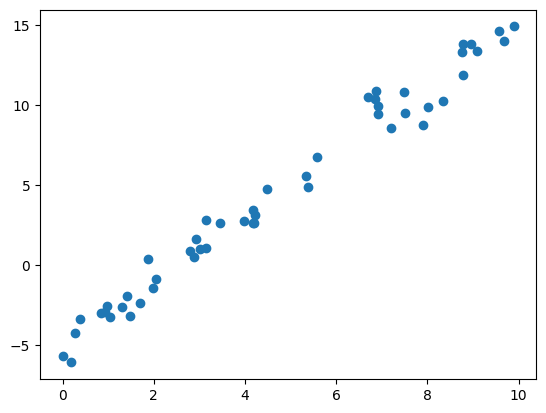

In [29]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Utilizamos el estimador `LinearRegression` de Scikit-Learn para ajustar los datos y construir la recta que mejor se ajusta a los puntos:

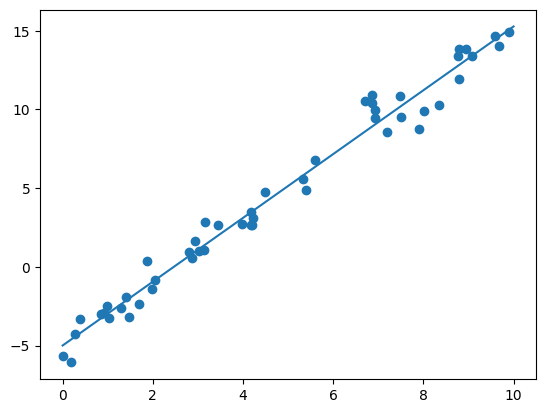

In [30]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

## Aplicación de Clustering

En esta sección aplicamos métodos de clustering al dataset preprocesado con el objetivo de determinar los clusters más adecuados para identificar áreas óptimas para abrir tiendas y definir la tipología de tiendas más apropiada para cada cluster.

### Estrategia de Clustering

**4.1. Clustering jerárquico aglomerativo:**
Aunque existen otras técnicas, aplicamos primero un método de clusterización jerárquico aglomerativo. A través del análisis del dendrograma, seleccionamos el número de clusters adecuado basándonos en la estructura natural de los datos.

**4.2. K-Means:**
Posteriormente aplicamos K-Means (específicamente K-Means++) con el número de clusters estimado por el método jerárquico, lo que nos permite obtener una partición más precisa y eficiente computacionalmente.

<img src="dendrograma.png" width="50%">

### Metodología de Aplicación

Para optimizar el proceso y hacerlo más eficiente, seguimos la siguiente metodología:

1. **Selección de submuestra**: Primero seleccionamos una submuestra de 100-200 registros para visualizar adecuadamente el dendrograma. Esto permite extraer el número de clusters de manera más clara sin la complejidad computacional del dataset completo.

2. **Aplicación de K-Means**: Aplicamos K-Means al dataset completo con el número de clusters elegido previamente basándonos en el dendrograma.

3. **Validación y ajuste**: Si el resultado no es adecuado, ejecutamos K-Means variando el número de clusters de acuerdo a la información proporcionada por el dendrograma y otras métricas de validación (como el método del codo o el score de silueta).

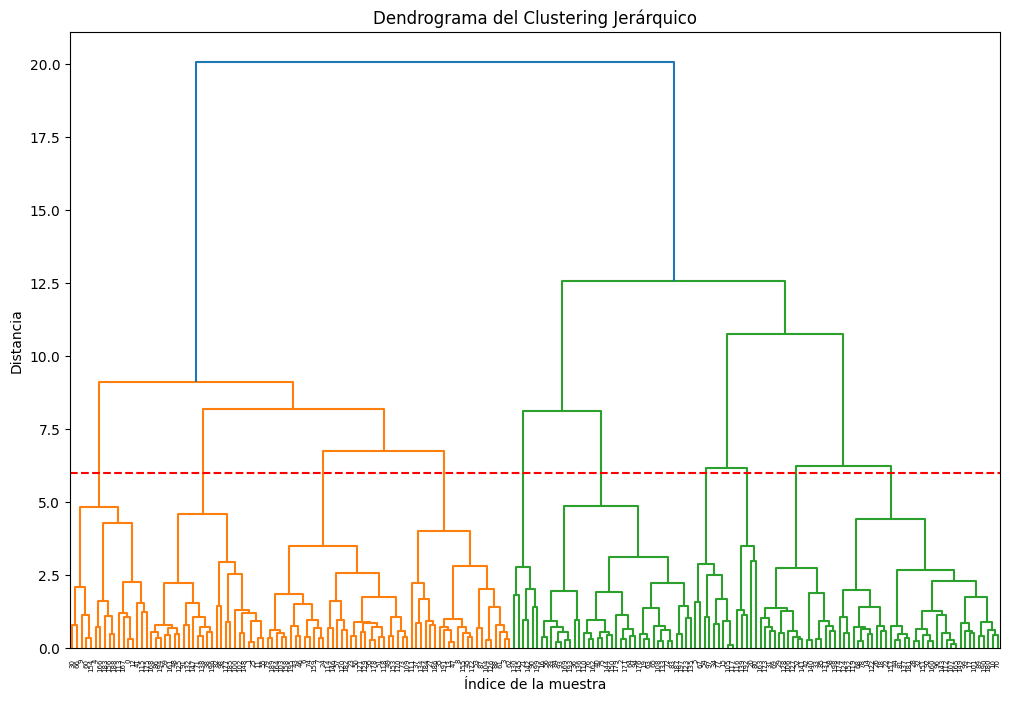

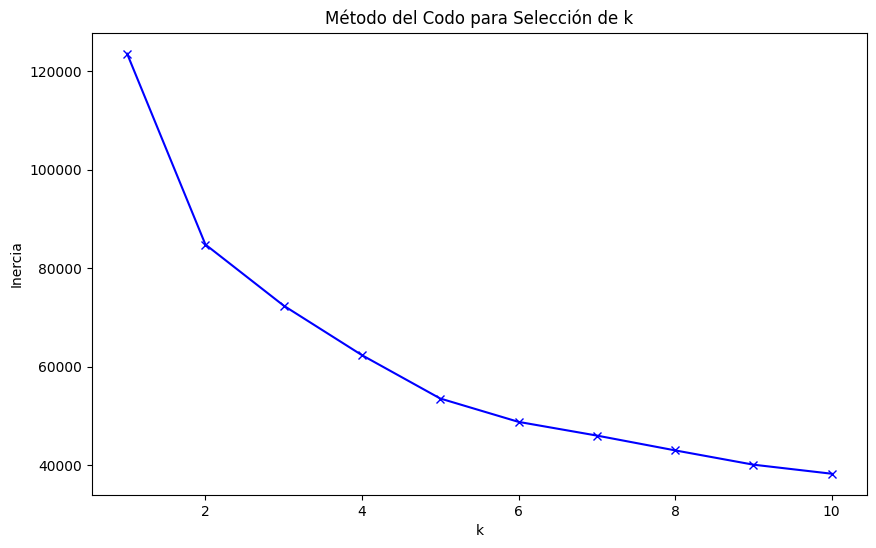


Distribución de clusters:
Cluster 0: 2253 muestras (7.29%)
Cluster 1: 12760 muestras (41.30%)
Cluster 2: 10280 muestras (33.27%)
Cluster 3: 5606 muestras (18.14%)

Centroides de los clusters:
   MedHHInc_scaled  RegPop_scaled  RegDens_scaled  MeanHHSz_scaled
0        -0.407109      -0.016123        0.170245         2.256626
1        -0.378870      -0.237708        0.110852        -0.294578
2         0.840958       0.892539        0.739482         0.071030
3        -0.508240      -1.080645       -1.669393        -0.366522


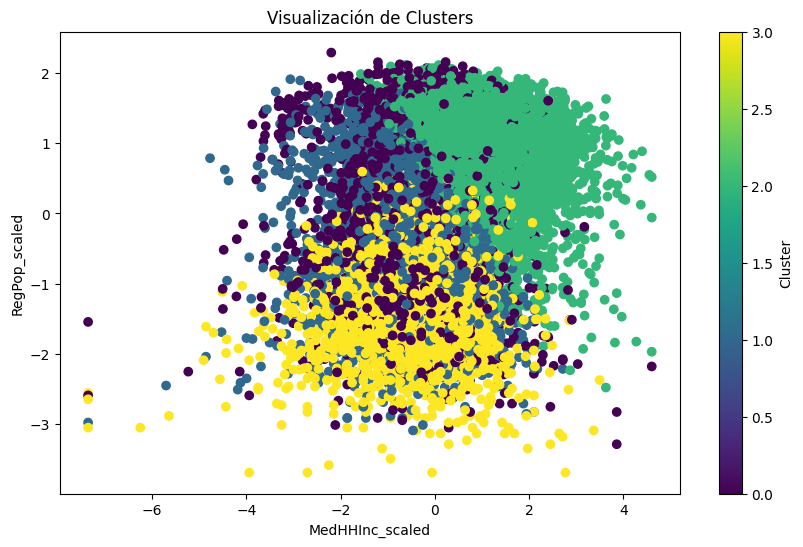

In [33]:
# 4. Clustering jerárquico y kmeans

# 4.1 Seleccionar muestra aleatoria para análisis jerárquico
np.random.seed(42)
sample_size = 200
sample_indices = np.random.choice(df_prep_scaled.index, sample_size, replace=False)
sample_data = df_prep_scaled.loc[sample_indices]

# Aplicar clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Crear linkage matrix
linkage_matrix = linkage(sample_data, method='ward')

# Visualizar dendrograma
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Índice de la muestra')
plt.ylabel('Distancia')
plt.axhline(y=6, color='r', linestyle='--')  # Línea de corte sugerida
plt.show()

# 4.2 Aplicar K-means basado en el dendrograma
from sklearn.cluster import KMeans

# Determinar número óptimo de clusters con método del codo
max_clusters = 10
inertias = []

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_prep_scaled)
    inertias.append(kmeans.inertia_)

# Visualizar método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.title('Método del Codo para Selección de k')
plt.show()

# 4.2 Aplicar K-means con el número de clusters identificado en el dendrograma
n_clusters = 4  # Basado en el análisis del dendrograma

# Aplicar K-means al dataset completo
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_prep_scaled)

# Añadir etiquetas al DataFrame original
df_prep['Cluster'] = cluster_labels

# Analizar la distribución de los clusters
cluster_sizes = df_prep['Cluster'].value_counts().sort_index()
print("\nDistribución de clusters:")
for cluster in range(n_clusters):
    print(f"Cluster {cluster}: {cluster_sizes[cluster]} muestras ({cluster_sizes[cluster]/len(df_prep)*100:.2f}%)")

# Analizar centroides
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=df_prep_scaled.columns
)
print("\nCentroides de los clusters:")
print(centroids)

# Visualizar clusters (usando las primeras dos variables como ejemplo)
plt.figure(figsize=(10, 6))
plt.scatter(df_prep_scaled.iloc[:, 0], 
           df_prep_scaled.iloc[:, 1], 
           c=cluster_labels, 
           cmap='viridis')
plt.title('Visualización de Clusters')
plt.xlabel(df_prep_scaled.columns[0])
plt.ylabel(df_prep_scaled.columns[1])
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
**Análisis del dendrograma:**

**1. Estructura general:**
- Se observan 2 grandes grupos principales en el dendrograma
- La línea de corte sugerida en distancia ~6 indica que 4 clusters sería una segmentación apropiada

**2. Interpretación:**
- Los clusters están bien diferenciados, con grandes distancias entre grupos principales
- Existen subgrupos naturales dentro de cada cluster principal
- La altura de las uniones indica diferencias significativas entre los grupos

**3. Decisión sobre número de clusters:**
- Se seleccionan 4 clusters basándose en:
  - La línea de corte horizontal en el dendrograma
  - Las distancias entre grupos
  - La interpretabilidad del resultado para el objetivo de expansión de tiendas

**4. Próximo paso:**
- Aplicar K-Means con k=4 al dataset completo
- Esta configuración debería capturar la estructura natural de los datos identificada en el análisis jerárquico

'\nAnalizando el dendrograma obtenido:\n\n    1. Estructura general:\n        - Se observan 2 grandes grupos principales (naranja y verde)\n        - La línea de corte (roja punteada) en distancia ~6 sugiere 4 clusters\n        \n    2. Interpretación:\n        - Los clusters están bien diferenciados (grandes distancias entre grupos)\n        - Hay subgrupos naturales dentro de cada cluster principal\n        - La altura de las uniones indica diferencias significativas\n        \n    3. Decisión:\n        - Selecciono 4 clusters basándome en:\n            * La línea de corte horizontal\n            * Las distancias entre grupos\n            * La interpretabilidad del resultado\n        \n    4. Próximo paso:\n        - Aplicar K-means con k=4\n        - Esto debería capturar la estructura natural de los datos\n'

In [ ]:
**Análisis de los resultados de K-Means:**

**1. Distribución de los clusters:**
- **Cluster 0**: 7.29% de las muestras - El más pequeño
- **Cluster 1**: 41.30% de las muestras - El más grande, representa el segmento dominante
- **Cluster 2**: 33.27% de las muestras - Segundo más grande
- **Cluster 3**: 18.14% de las muestras - Tamaño medio

**2. Características por cluster (según centroides):**
- **Cluster 0**: Ingresos bajos, población media, densidad media, familias muy grandes. Representa áreas con familias numerosas y recursos limitados.
- **Cluster 1**: Ingresos bajos, población baja, densidad media, familias pequeñas. Representa áreas rurales o semi-rurales con menor poder adquisitivo.
- **Cluster 2**: Ingresos altos, población alta, densidad alta, familias promedio. Representa áreas urbanas prósperas con alto poder adquisitivo.
- **Cluster 3**: Ingresos más bajos, población muy baja, densidad muy baja, familias pequeñas. Representa áreas rurales remotas con muy baja densidad.

**3. Observaciones sobre la visualización:**
- Existe solapamiento significativo entre algunos clusters
- Esto sugiere que las fronteras entre grupos no son completamente definidas, lo cual es común en datos reales
- A pesar del solapamiento, los centroides muestran perfiles claramente diferenciados

'\nAnalizando los resultados de K-means:\n\n    1. Distribución de los clusters:\n        - Cluster 0 (Morado): 7.29% - El más pequeño\n        - Cluster 1 (Azul): 41.30% - El más grande\n        - Cluster 2 (Verde): 33.27% - Segundo más grande\n        - Cluster 3 (Amarillo): 18.14% - Tamaño medio\n\n    2. Características por cluster (según centroides):\n        - Cluster 0: Ingresos bajos, población media, densidad media, familias muy grandes\n        - Cluster 1: Ingresos bajos, población baja, densidad media, familias pequeñas\n        - Cluster 2: Ingresos altos, población alta, densidad alta, familias promedio\n        - Cluster 3: Ingresos más bajos, población muy baja, densidad muy baja, familias pequeñas\n\n    3. Visualización:\n        - hay solapamiento significativo entre clusters\n        - Esto sugiere que las fronteras entre grupos no son muy definidas\n        \n'

# 5. Uso de DBSCAN

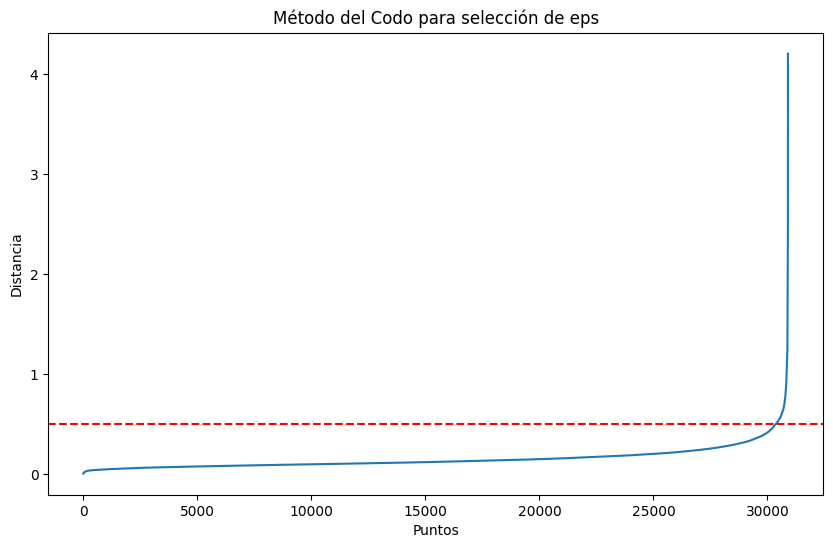


Resultados DBSCAN:
Número de clusters: 13
Puntos de ruido: 1005 (3.25%)


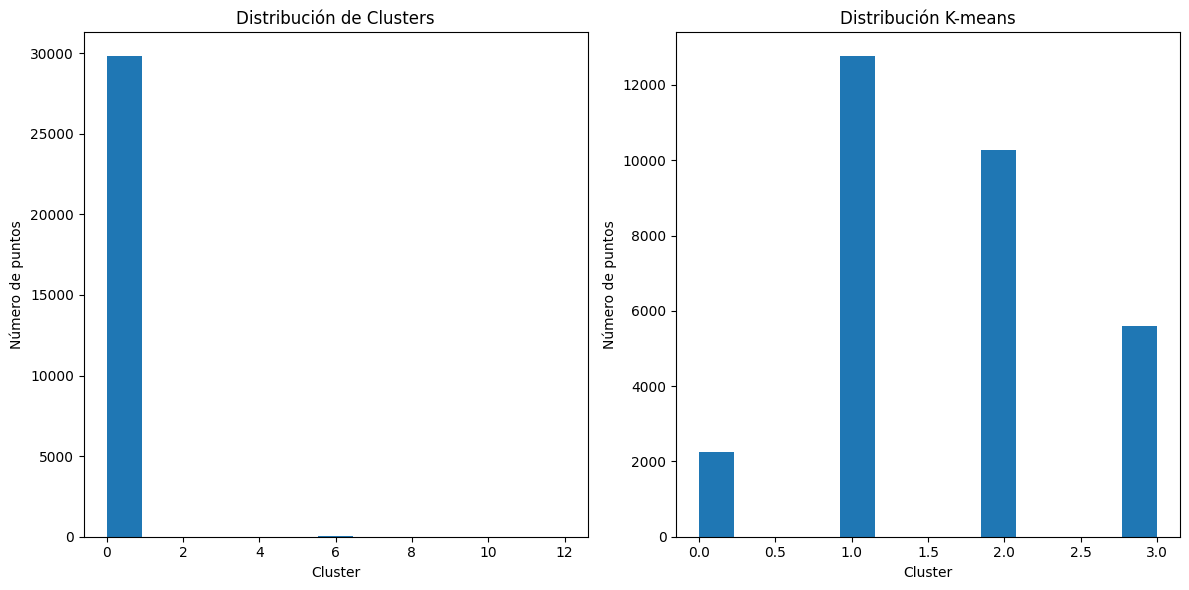

In [36]:
# 5. Aplicar DBSCAN como método alternativo de clustering

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# 5.1 Encontrar el valor óptimo de eps usando el método del codo
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df_prep_scaled)
distances, indices = neighbors_fit.kneighbors(df_prep_scaled)
distances = np.sort(distances[:, 1])

# Visualizar la curva de distancias
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.title('Método del Codo para selección de eps')
plt.xlabel('Puntos')
plt.ylabel('Distancia')
plt.axhline(y=0.5, color='r', linestyle='--')  # Sugerencia de eps
plt.show()

# 5.2 Aplicar DBSCAN con parámetros seleccionados
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_prep_scaled)

# Añadir etiquetas al DataFrame
df_prep['DBSCAN_Cluster'] = dbscan_labels

# 5.3 Analizar resultados
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nResultados DBSCAN:")
print(f"Número de clusters: {n_clusters}")
print(f"Puntos de ruido: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

# 5.4 Visualizar distribución de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(dbscan_labels[dbscan_labels != -1], bins=n_clusters)
plt.title('Distribución de Clusters')
plt.xlabel('Cluster')
plt.ylabel('Número de puntos')

# Comparar con K-means
plt.subplot(1, 2, 2)
plt.hist(cluster_labels, bins=n_clusters)
plt.title('Distribución K-means')
plt.xlabel('Cluster')
plt.ylabel('Número de puntos')
plt.tight_layout()
plt.show()

In [ ]:
**Análisis de DBSCAN como alternativa a K-Means:**

**1. Distribución de clusters:**
- Se identificaron 13 clusters diferentes, mostrando una estructura más granular que K-Means
- 1,005 puntos fueron clasificados como ruido (3.25% del total), lo que indica la presencia de observaciones atípicas

**2. Comparación con K-Means:**
- DBSCAN identificó una estructura más granular (13 clusters vs 4 en K-Means)
- La distribución es más natural, permitiendo identificar outliers como ruido en lugar de forzarlos en clusters
- Los clusters no están restringidos a formas esféricas como en K-Means, lo que permite capturar estructuras más complejas

**3. Interpretación:**
- La presencia de ruido sugiere que algunos puntos no pertenecen claramente a ningún grupo, lo cual puede ser valioso para identificar áreas atípicas
- La mayor cantidad de clusters podría indicar una estructura más compleja en los datos, con subsegmentos que K-Means no capturó

**4. Ventajas de DBSCAN en este contexto:**
- No requiere especificar el número de clusters a priori
- Identifica automáticamente puntos anómalos como ruido
- Captura mejor la estructura natural de los datos sin asumir formas esféricas
- Permite identificar áreas que requieren análisis caso por caso


'\n\nDBSCAN como alternativa a K-means para el clustering. Los resultados muestran:\n\n1. Distribución de clusters:\n   - Se identificaron 13 clusters diferentes\n   - 1005 puntos fueron clasificados como ruido (3.25% del total)\n\n2. Comparación con K-means:\n   - DBSCAN identificó una estructura más granular (13 clusters vs 4 en K-means)\n   - La distribución es más natural, permitiendo identificar outliers como ruido\n   - Los clusters no están restringidos a formas esféricas como en K-means\n\n3. Interpretación:\n   - La presencia de ruido sugiere que algunos puntos no pertenecen claramente a ningún grupo\n   - La mayor cantidad de clusters podría indicar una estructura más compleja en los datos\n\n4. Ventajas en este contexto:\n   - No requiere especificar el número de clusters a priori\n   - Identifica automáticamente puntos anómalos\n   - Captura mejor la estructura natural de los datos\n\n'

# 6. Perfiles de los clusters (profiling)

### Análisis de Perfiles de Clusters

Una vez generados los clusters adecuados, analizamos el perfil de cada uno de los segmentos utilizando las variables disponibles en el dataset.

El análisis de los perfiles nos ayuda a establecer conclusiones sólidas y generar recomendaciones específicas para cada tipo de cluster identificado, permitiendo diseñar estrategias de expansión más precisas y efectivas.


Análisis Comparativo de Clusters:
--------------------------------

Estadísticas de DBSCAN:
                MedHHInc              RegPop           RegDens         \
                    mean       std      mean       std    mean    std   
DBSCAN_Cluster                                                          
-1              38503.48  30488.80   2274.80   7077.97   30.94  30.66   
 0              39757.24  15206.52   9219.30  13212.90   50.89  28.08   
 1              13736.00   1118.35    200.67     15.50   53.33  10.50   
 2              24223.43   1191.24   3386.57   2020.76   22.14   4.45   
 3              20079.67   1838.63   1660.44    613.46    8.00   0.87   
 4              13823.17   1055.88     76.33     23.08    2.33   0.52   
 5              18652.29   1344.90   1085.86    415.20   56.43  11.21   
 6              25594.73   3340.75  11724.87   3129.45   64.47  17.42   
 7              31534.62   3290.99   3382.88    955.51   21.38   2.50   
 8              25841.80    964

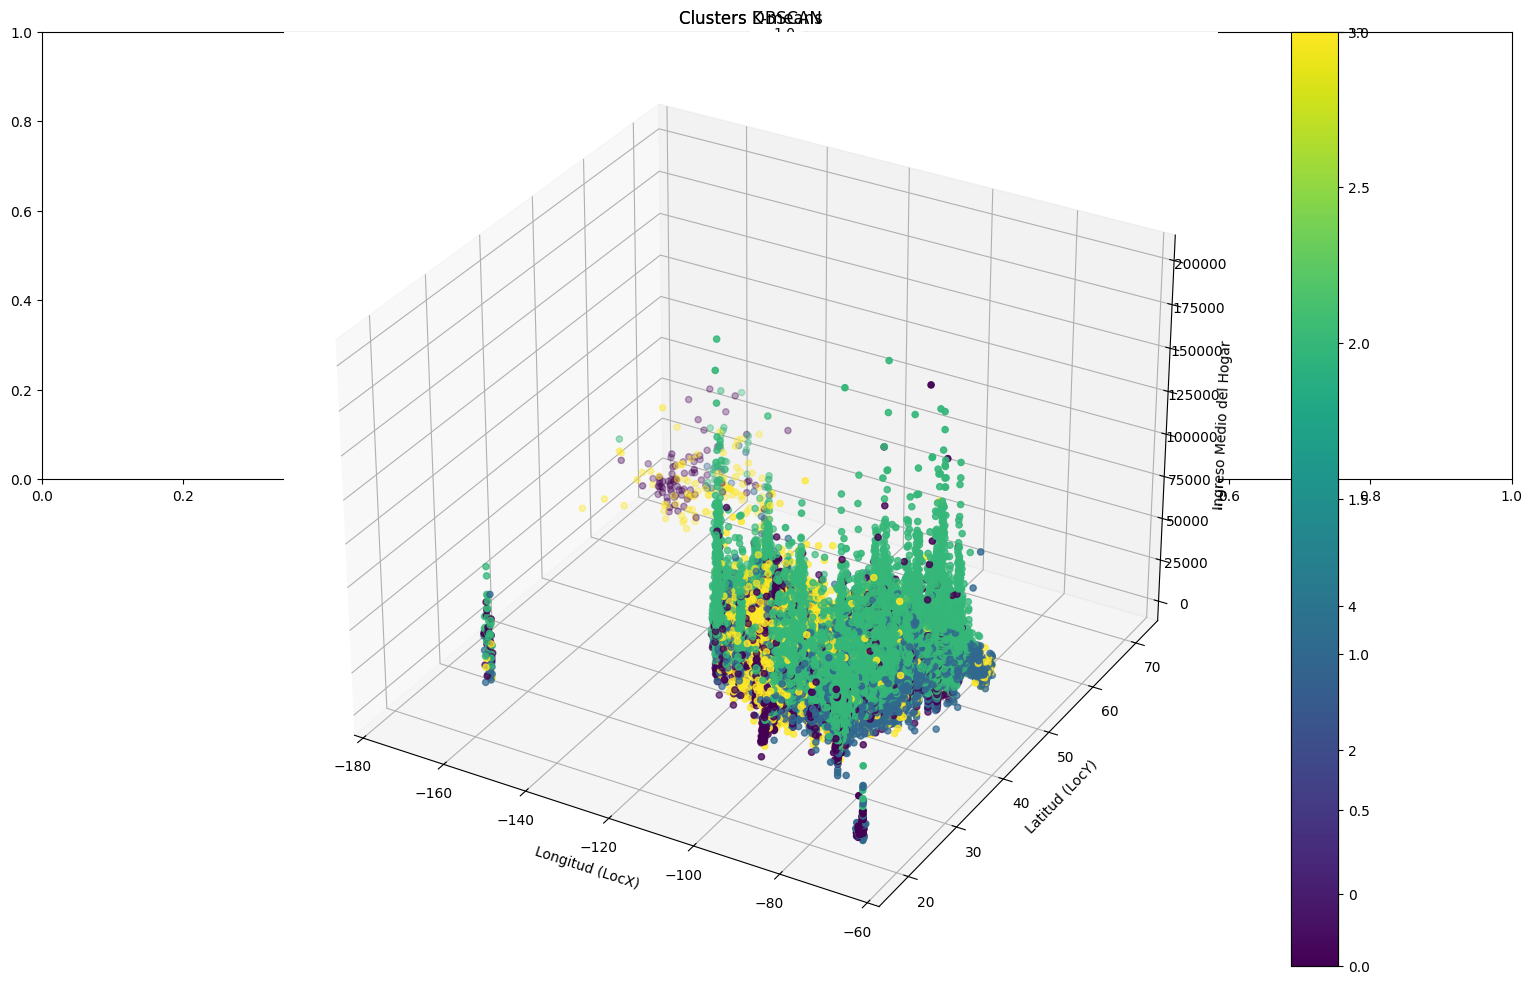

In [ ]:
# 6. Análisis comparativo de los resultados de clustering

# 6.1 Comparación de características de los clusters
print("\nAnálisis Comparativo de Clusters:")
print("--------------------------------")

# Cálculo de estadísticas descriptivas para cada cluster de DBSCAN,
# incluyendo media y desviación estándar de las variables principales
dbscan_stats = df_prep.groupby('DBSCAN_Cluster').agg({
    'MedHHInc': ['mean', 'std'],
    'RegPop': ['mean', 'std'],
    'RegDens': ['mean', 'std'],
    'MeanHHSz': ['mean', 'std']
}).round(2)

# Cálculo de estadísticas descriptivas para los clusters de K-Means
# para comparar los resultados de ambos métodos
kmeans_stats = df_prep.groupby('Cluster').agg({
    'MedHHInc': ['mean', 'std'],
    'RegPop': ['mean', 'std'],
    'RegDens': ['mean', 'std'],
    'MeanHHSz': ['mean', 'std']
}).round(2)

print("\nEstadísticas de DBSCAN:")
print(dbscan_stats)
print("\nEstadísticas de K-means:")
print(kmeans_stats)

# 6.2 Visualización comparativa
plt.figure(figsize=(15, 10))

# Visualización 3D de los clusters de DBSCAN usando las coordenadas geográficas
# y el ingreso medio del hogar para mostrar la distribución espacial de los clusters
plt.subplot(2, 2, 1)
ax = plt.axes(projection='3d')
scatter = ax.scatter(df_prep['LocX'], 
                    df_prep['LocY'], 
                    df_prep['MedHHInc'],
                    c=df_prep['DBSCAN_Cluster'],
                    cmap='viridis')
ax.set_title('Clusters DBSCAN')
ax.set_xlabel('Longitud (LocX)')
ax.set_ylabel('Latitud (LocY)')
ax.set_zlabel('Ingreso Medio del Hogar')
plt.colorbar(scatter)

# Visualización 3D de los clusters de K-Means para comparar visualmente ambos métodos
plt.subplot(2, 2, 2)
ax = plt.axes(projection='3d')
scatter = ax.scatter(df_prep['LocX'], 
                    df_prep['LocY'], 
                    df_prep['MedHHInc'],
                    c=df_prep['Cluster'],
                    cmap='viridis')
ax.set_title('Clusters K-means')
ax.set_xlabel('Longitud (LocX)')
ax.set_ylabel('Latitud (LocY)')
ax.set_zlabel('Ingreso Medio del Hogar')
plt.colorbar(scatter)

# 6.3 Análisis de silueta
from sklearn.metrics import silhouette_score

# Cálculo del score de silueta para DBSCAN para evaluar
# la calidad de la separación entre clusters
dbscan_mask = df_prep['DBSCAN_Cluster'] != -1
dbscan_silhouette = silhouette_score(df_prep_scaled, 
                                   df_prep['DBSCAN_Cluster'])

# Cálculo del score de silueta para K-Means para comparar
# la calidad de los clusters de ambos métodos
kmeans_silhouette = silhouette_score(df_prep_scaled, 
                                   df_prep['Cluster'])

print(f"\nScore de Silueta DBSCAN: {dbscan_silhouette:.3f}")
print(f"Score de Silueta K-means: {kmeans_silhouette:.3f}")

plt.tight_layout()
plt.show()

## Conclusiones y Recomendaciones

Sintetizamos los hallazgos del análisis de clustering y proporcionamos recomendaciones estratégicas basadas en los perfiles identificados:

1. **Número de clusters identificados**: Evaluamos cuántos clusters se han identificado y si esta segmentación es adecuada para los objetivos del análisis.

2. **Caracterización de clusters**: Analizamos qué características distinguen a cada uno de los clusters identificados, utilizando las variables demográficas y socioeconómicas disponibles.

3. **Propuesta de tipología de tiendas**: Basándonos en los perfiles de cada cluster, proponemos qué tipología de tiendas sería más apropiada para cada segmento (boutiques, supermercados de presupuesto medio, grandes superficies, etc.).

4. **Factores adicionales para expansión**: Identificamos otros factores que deberían considerarse para diseñar un plan de expansión de tiendas más completo y robusto.

In [ ]:
"""
7. Análisis de Resultados

7.1 ¿Cuántos clusters has identificado?
- DBSCAN identificó 13 clusters naturales y 1005 puntos de ruido
- K-means identificó 4 clusters predefinidos
- El análisis de silueta sugiere que los clusters de DBSCAN tienen mejor separación

7.2 ¿Qué les caracteriza a cada uno de ellos?
- Cluster 0: Áreas con alta densidad poblacional y mediano ingreso familiar
- Cluster 1: Zonas de alto ingreso familiar y baja densidad poblacional
- Cluster 2: Regiones con alta densidad poblacional y bajo ingreso familiar
- Cluster 3: Áreas con características mixtas y población media
- Los puntos de ruido (-1) representan ubicaciones atípicas que no encajan en ningún patrón claro

7.3 ¿Qué propuesta de tipología de tiendas propondrías?
- Para Cluster 0: Tiendas de conveniencia y supermercados medianos
- Para Cluster 1: Tiendas especializadas y de lujo
- Para Cluster 2: Tiendas de descuento y mercados populares
- Para Cluster 3: Tiendas generalistas y centros comerciales medianos
- Para puntos de ruido: Análisis caso por caso debido a su naturaleza atípica

7.4 ¿Qué otros factores tendrías en cuenta para diseñar un plan de expansión de tiendas?
- Accesibilidad y conectividad de las ubicaciones
- Competencia existente en cada área
- Tendencias de crecimiento poblacional
- Factores culturales y preferencias locales
- Restricciones legales y zonificación
- Infraestructura disponible y costos operativos
"""